# Dual-Channel CNN

## Import relevant Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline
import os, random, shutil
from skimage.io import imread, imshow
from skimage.filters import prewitt_h, prewitt_v

In [2]:
import h5py

In [3]:
import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [4]:
from tensorflow.keras.preprocessing import image
from PIL import Image
import numpy as np

In [5]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


new file with formated images 

## Create A Data Frame For Labels

In [7]:
labels = ['allo/', 'amio/', 'clari/', 'furo/', 'irb/', 'levo/', 'simva/', 'trama/']

In [8]:
kinds = ['RGB_formated', 'Dual_Channel_NIR_Images_resized_400x400']

drive_path = 'gdrive/My Drive/'
source_RGB = drive_path + 'RGB_formated/'
source_NIR = drive_path +  'Dual_Channel_NIR_Images_resized_400x400/'


In [9]:
for label in labels:
    files_RGB = os.listdir(source_RGB + label)
    files_NIR = os.listdir(source_NIR + label)
    for file_NIR in files_NIR:
        if file_NIR == '.DS_Store':
            #shutil.rmtree(dest + label + file_NIR)
            os.remove(source_NIR+label+file_NIR)
    for file_RGB in files_RGB:
        if file_RGB == '.DS_Store':
            #shutil.rmtree(dest + label + file_NIR)
            os.remove(source_RGB+label+file_RGB)

In [10]:
for label in labels:
    files_NIR = os.listdir(source_NIR + label)
    

    for files_NIR in files_NIR:
        
        if file_NIR == '.DS_Store':
        #shutil.rmtree(dest + label + file_NIR)
            os.remove(source_NIR +label+file_NIR)
        if file_NIR.find('(1)') != -1:
            print( file_NIR)
            os.remove(source_NIR+label+file_NIR)

for label in labels:

     files_RGB = os.listdir(source_RGB + label)

     for file_RGB in files_RGB:
        
         if file_RGB == '.DS_Store':
          #shutil.rmtree(dest + label + file_RGB)
             os.remove(source_RGB +label+file_RGB)
         if file_RGB.find('(1)') != -1: # (1) refers to files that are in multiple version, ex: image_1.png and image_1(1).png
             print( file_RGB)
             os.remove(source_RGB+label+file_RGB+'/'+image_RGB)


#Remove files in one of the dataset, in this case NIR has 453 files more than RGB dataset. We remove them randomly and equaly across folders

In [ ]:
from random import sample

for label in labels:
    
    files = os.listdir(source_NIR + label)

    for file in sample(files,453):
        os.remove( source_NIR +label + file)

In [11]:


RGB_ID = []
RGB_Pill_name = []
NIR_ID = []
NIR_Pill_name = []




for label in labels:
    files_RGB = os.listdir( source_RGB + label)
    files_NIR = os.listdir(source_NIR + label)
    
    for file_RGB in files_RGB: 
        RGB_ID.append(file_RGB)
        RGB_Pill_name.append(label.translate({ord('/'): None}))
    
    for file_NIR in files_NIR: 
        NIR_ID.append(file_NIR)
        NIR_Pill_name.append(label.translate({ord('/'): None}))
        

rgb = {'RGB_ID': RGB_ID , 'Pill_name': RGB_Pill_name }
nir = {'NIR_ID': NIR_ID , 'Pill_name': NIR_Pill_name }

RGB_df = pd.DataFrame(data=rgb)
NIR_df = pd.DataFrame(data=nir)

In [12]:
NIR_df #4407

,NIR_ID,Pill_name
0,bug_allo_32_bug_image6.jpg,allo
1,bug_allo_410_bug_image8.jpg,allo
2,aug_allo_1979_aug_image8.jpg,allo
3,aug_allo_1974_aug_image4.jpg,allo
4,aug_allo_870_aug_image8.jpg,allo
...,...,...
778,aug_trama_144312_aug_image9.jpg,trama
779,aug_trama_134300_aug_image2.jpg,trama
780,aug_trama_154340_aug_image9.jpg,trama
781,aug_trama_124341_aug_image7.jpg,trama


In [13]:
# Create a folder with evrything RGB and other one with NIR

In [14]:
dest_rgb = drive_path + 'RGB_tout/' #if code already run before just run this cell and not the two following ones
dest_nir = drive_path + 'NIR_tout/'

In [ ]:
kinds = ['RGB_tout', 'NIR_tout']

for kind in kinds:
    os.mkdir(drive_path + kind)

In [ ]:
dest_rgb = drive_path + 'RGB_tout/'
dest_nir = drive_path + 'NIR_tout/'

for label in labels:
    
    files_RGB_tout = os.listdir(source_RGB + label)
    files_NIR_tout = os.listdir( source_NIR + label)
    
    for file_RGB_tout in files_RGB_tout: 
        
        if file_RGB_tout != '.DS_Store' and file_RGB_tout.endswith('.HEIC') == False  :
        
            #shutil.move(drive_path + source_RGB + label + file_RGB_tout, dest_rgb)
            image_tout_rgb = Image.open( source_RGB + label + file_RGB_tout)
            image_tout_rgb.save(dest_rgb + file_RGB_tout )
    
    for file_NIR_tout in files_NIR_tout: 
        
        if file_NIR_tout != '.DS_Store' and file_NIR_tout.endswith('.HEIC') == False  :
        
            #shutil.move(drive_path + source_NIR + label + file_NIR_tout, dest_nir)
            image_tout_nir = Image.open( source_NIR + label + file_NIR_tout)
            image_tout_nir.save(dest_nir + file_NIR_tout )
           

In [15]:
as_gray = False
in_channel = 3
img_rows, img_cols = 400, 400
num_classes = 8 # number of types

batch_size = 8
epochs = 50
input_shape = (img_rows, img_cols, in_channel)
input_img = Input(shape = input_shape)

In [16]:
def read_spectograms(file_paths, img_rows, img_cols, as_gray, channels,sample):

  images = []
  
  for file_path in file_paths:
    images.append(imread(file_path, as_gray = as_gray ))
  
  images = np.asarray(images, dtype=np.float32)
  
  # normalize
  images = images / 255.0 #np.max(images)
  
  # reshape to match Keras expectaions
  images = images.reshape(sample, img_rows, img_cols, channels)

  return images

In [17]:


x_train_RGB = read_spectograms(dest_rgb +  RGB_df.RGB_ID.values, img_rows, img_cols, as_gray , in_channel,783)


x_train_NIR = read_spectograms(dest_nir + NIR_df.NIR_ID.values, img_rows, img_cols, as_gray, in_channel,783)



In [18]:
labels_RGB = RGB_df.Pill_name.values
labels_RGB

array(['allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo',
       'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo',
       'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo',
       'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo',
       'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo',
       'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo',
       'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo',
       'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo',
       'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo',
       'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo',
       'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo',
       'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo',
       'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo',
       'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo', 'allo',
      

In [19]:
labels_NIR = NIR_df.Pill_name.values

In [20]:
labels_RGB = np.where(labels_RGB== 'allo', 0, labels_RGB)
labels_RGB = np.where(labels_RGB== 'amio', 1, labels_RGB)
labels_RGB = np.where(labels_RGB== 'clari', 2, labels_RGB)
labels_RGB = np.where(labels_RGB== 'furo', 3, labels_RGB)
labels_RGB = np.where(labels_RGB== 'irb', 4, labels_RGB)
labels_RGB = np.where(labels_RGB== 'levo', 5, labels_RGB)
labels_RGB = np.where(labels_RGB== 'simva', 6, labels_RGB)
labels_RGB = np.where(labels_RGB== 'trama', 7, labels_RGB)

In [21]:
labels_NIR = np.where(labels_NIR== 'allo', 0, labels_NIR)
labels_NIR = np.where(labels_NIR== 'amio', 1, labels_NIR)
labels_NIR = np.where(labels_NIR== 'clari', 2, labels_NIR)
labels_NIR = np.where(labels_NIR== 'furo', 3, labels_NIR)
labels_NIR = np.where(labels_NIR== 'irb', 4, labels_NIR)
labels_NIR= np.where(labels_NIR== 'levo', 5, labels_NIR)
labels_NIR = np.where(labels_NIR== 'simva', 6, labels_NIR)
labels_NIR = np.where(labels_NIR== 'trama', 7,labels_NIR)

In [22]:
# labels - convert class vectors to binary class matrices One Hot Encoding

labels_RGB = keras.utils.to_categorical(labels_RGB, num_classes)

In [23]:
labels_NIR = keras.utils.to_categorical(labels_NIR, num_classes)

# Split and Train test batches

In [24]:

# stack so we can split on the same pair of images
x_train_comp = np.stack((x_train_RGB, x_train_NIR), axis=4)

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, labels_RGB, test_size = 0.3, random_state=666)

# take them apart
x_train_RGB = x_train[:,:,:,:,0]
x_test_RGB = x_test[:,:,:,:,0]

x_train_NIR = x_train[:,:,:,:,1]
x_test_NIR = x_test[:,:,:,:,1]

# Model

In [25]:
def create_convolution_layers(input_img):
  model = Conv2D(32, (3, 3), padding='same', input_shape=input_shape)(input_img)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D((2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
  
  model = Conv2D(64, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
    
  model = Conv2D(128, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.4)(model)


    
  return model

In [26]:
RGB_input = Input(shape=input_shape)
RGB_model = create_convolution_layers(RGB_input)

NIR_input = Input(shape=input_shape)
NIR_model = create_convolution_layers(NIR_input)

conv = concatenate([RGB_model, NIR_model])

conv = Flatten()(conv)

dense = Dense(512)(conv)


dense = LeakyReLU(alpha=0.1)(dense)
dense = Dropout(0.5)(dense)

output = Dense(num_classes, activation='softmax')(dense)

model = Model(inputs=[RGB_input, NIR_input], outputs=[output])

In [27]:

opt = optimizers.Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 400, 400, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 400, 400, 32) 896         input_3[0][0]                    
______________________________________________________________________________________________

# Train the model 

In [28]:

best_weights_file="weights_best.hdf5"
best_weights_file_dir = os.path.dirname(drive_path + best_weights_file)


In [29]:
best_weights_file_dir

'gdrive/My Drive'

In [30]:
#batch_size = 783
checkpoint = keras.callbacks.ModelCheckpoint(best_weights_file, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [checkpoint]

history = model.fit([x_train_RGB, x_train_NIR], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    verbose=1,
                    validation_data=([x_test_RGB, x_test_NIR], y_test),
                    shuffle=True)

Epoch 1/50
69/69 [==============================] - 25s 129ms/step - loss: 26.9692 - accuracy: 0.1537 - val_loss: 13.7842 - val_accuracy: 0.1489

Epoch 00001: val_accuracy improved from -inf to 0.14894, saving model to weights_best.hdf5
Epoch 2/50
69/69 [==============================] - 8s 114ms/step - loss: 2.1819 - accuracy: 0.1537 - val_loss: 16.2379 - val_accuracy: 0.1447

Epoch 00002: val_accuracy did not improve from 0.14894
Epoch 3/50
69/69 [==============================] - 8s 113ms/step - loss: 2.0353 - accuracy: 0.1698 - val_loss: 10.7302 - val_accuracy: 0.1745

Epoch 00003: val_accuracy improved from 0.14894 to 0.17447, saving model to weights_best.hdf5
Epoch 4/50
69/69 [==============================] - 8s 113ms/step - loss: 2.3453 - accuracy: 0.1369 - val_loss: 3.0199 - val_accuracy: 0.1404

Epoch 00004: val_accuracy did not improve from 0.17447
Epoch 5/50
69/69 [==============================] - 8s 113ms/step - loss: 1.9996 - accuracy: 0.2018 - val_loss: 4.6138 - val_acc

# Evaluation

In [ ]:
#model = create_model()
# load weights 0.0474


final_loss, final_acc = model.evaluate([x_test_RGB, x_test_NIR], y_test, verbose=1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))  

8/8 [==============================] - 1s 106ms/step - loss: 12.6512 - accuracy: 0.2298
Final loss: 12.651244, final accuracy: 0.229787


In [31]:
model.load_weights(best_weights_file)

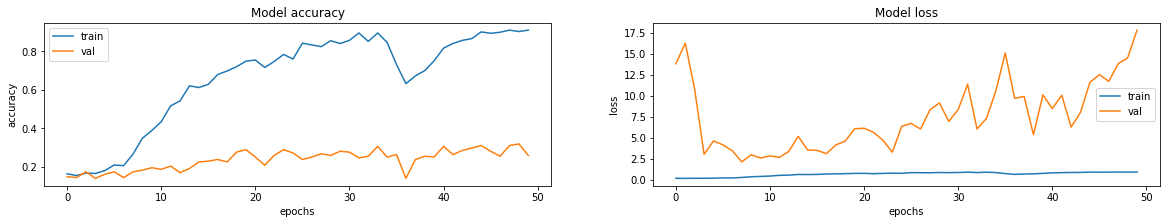

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history['accuracy'])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

plt.savefig('gdrive/My Drive/Dual_Channel_Final_Graphs_1.jpg')

# Predict 

In [ ]:
predict_df = pd.concat([RGB_df,NIR_df], axis=1)

In [ ]:
predict_df

,RGB_ID,Pill_name,NIR_ID,Pill_name
0,IMG_7380.JPG,allo,45image7 (8).jpg,allo
1,IMG_7394.JPG,allo,20image4 (7).jpg,allo
2,IMG_7223.JPG,allo,3image7 (10).jpg,allo
3,IMG_7814.JPG,allo,75image4 (4).jpg,allo
4,IMG_7828.JPG,allo,10image3 (13).jpg,allo
...,...,...,...,...
778,IMG_7832.JPG,trama,764image3 (10).jpg,trama
779,IMG_6888.JPG,trama,744image7 (5).jpg,trama
780,IMG_6455.JPG,trama,772image3 (11).jpg,trama
781,IMG_7818.JPG,trama,741image3 (6).jpg,trama


In [ ]:
os.getcwd()

'/content'

In [ ]:
#predict_df = pd.read_csv('RGB.csv', index_col=0)

#predict_df['RGB_ID'] = predict_df.index.map(lambda id: f'{id}.JPG')
#predict_df['NIR_ID'] = predict_df.index.map(lambda id: f'{id}.jpg')

x_test_RGB = read_spectograms(dest_rgb + predict_df.RGB_ID.values, img_rows, img_cols, as_gray, in_channel,783)
x_test_NIR = read_spectograms(dest_nir + predict_df.NIR_ID.values, img_rows, img_cols, as_gray, in_channel,783)
#x_train_NIR = read_spectograms(dest_nir + NIR_df.NIR_ID.values, img_rows, img_cols, as_gray, in_channel,783)

In [ ]:
#get the predictions for the test data
predicted_classes = model.predict([x_test_RGB, x_test_NIR])

predict_df.appliance = np.argmax(predicted_classes,axis=1)
predict_df = predict_df.drop(['RGB_ID', 'NIR_ID'], axis=1)
predict_df.to_csv('gdrive/My Drive/submission.csv')

from google.colab import files
files.download('gdrive/My Drive/submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>